<a href="https://colab.research.google.com/github/vignesh-0510/SolarFlareExplainableWindowDetection/blob/main/phase_3_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dowload and Import Libraries

In [ ]:
!pip install shap imbalanced-learn

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, jaccard_score
from imblearn.metrics import geometric_mean_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import tqdm
import pickle
from collections import deque
import shap
from os.path import curdir

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing Functions

In [4]:
def extract_start_end_time(filename):
  """Extracts start and end time from a filename string.

  Args:
    filename: The filename string in the format
      'FQ_ar146_s2010-08-29T17:12:00_e2010-08-30T05:00:00.csv'.

  Returns:
    A tuple containing the start time and end time strings, or None if the
    filename does not match the expected format.
  """
  try:
    parts = filename.split('_')
    start_time_part = parts[2][1:]  # Remove 's' prefix
    end_time_part = parts[3][1:]   # Remove 'e' prefix
    return start_time_part, end_time_part
  except IndexError:
    return None, None

def process_filename(file_path):
  file_dict = {}
  filename = os.path.basename(file_path).split('.csv')[0]
  file_dict['filename'] = filename
  category = ''
  if filename[:2] == 'FQ':
    category = 'FQ'
    sub_category = 'NA'
  else:
    category = filename[0]
    sub_category = filename.split('@')[0][1:]
  file_dict['category'] = category
  if category in ('FQ', 'A', 'B', 'C'):
    file_dict['class'] = 'NF'
  else:
    file_dict['class'] = 'FL'

  file_dict['sub_category'] = sub_category
  start_time, end_time = extract_start_end_time(filename)
  file_dict['start_time'] = start_time
  file_dict['end_time'] = end_time
  return file_dict

def min_max_scaling(data, min_val, max_val):
  norm_data = (data - min_val) / (max_val - min_val)
  return norm_data

def process_file(df, interacting_columns, meta_dict, file_info, frequency_modes= 10):
  modes = frequency_modes // 2
  data_arr = np.zeros((frequency_modes*len(interacting_columns),1))

  data_col_list = []
  for i, col in enumerate(interacting_columns):
    y = df[col].values
    y = min_max_scaling(y, meta_dict[col]['min'], meta_dict[col]['max'])

    y_f = torch.fft.rfft(torch.tensor(y))
    y_f = torch.cat((y_f[:modes], y_f[-modes:]))
    data_col_list.extend([f'{col}_real_{c}' for c in range(frequency_modes)])
    data_arr[i*frequency_modes: (i+1)*frequency_modes,0] = torch.real(y_f).numpy()
  result_df = pd.DataFrame(data_arr.T, columns=data_col_list)
  result_df['class'] = file_info['class']
  return result_df

# Loading Data, Model and Metadata


In [5]:
file_path = '/content/drive/MyDrive/ADM/interpret_data/X3.1@9128:Primary_ar4698_s2014-10-23T10:12:00_e2014-10-23T22:00:00.csv'
model = None
meta_dict = None

with open('/content/drive/MyDrive/ADM/results/part_123/rf_clf.pkl', 'rb') as f:
  model = pickle.load(f)

with open('/content/drive/MyDrive/ADM/partition1/swan-sf-metadata.pkl', 'rb') as f:
  meta_dict = pickle.load(f)

interacting_columns = ['TOTUSJH', 'TOTPOT', 'TOTUSJZ']
file_info = process_filename(file_path)
instance_df = pd.read_csv(file_path, sep='\t', usecols=interacting_columns)

# Utility Components

In [6]:
class Node:
  def __init__(self, start=None, size=None, confidence=None, parent=None):
    self.window_start = start
    self.window_size = size
    self.window_end = start + size
    self.confidence = confidence
    self.parent = parent

In [7]:
def run_analysis(df,interacting_columns, model, file_info,freq_modes = 10):

  freq_df = process_file(df, interacting_columns, meta_dict, file_info, freq_modes)
  X_df = freq_df[[col for col in freq_df.columns if col != 'class']]
  y_df = freq_df['class']
  c = model.predict_proba(X_df)
  # print(f'confidence of FL: {c}')
  # print(f'normalized_conf {1-(c[0] - y_df["class"].values)}')
  normalized_confidence = 0
  if file_info['class'] == 'NF':
    return c[0][1]
  else:
    return c[0][0]

# Tail Chopping Algorithm

In [ ]:
def run_tail_chopping_algorithm(instance_df, model, file_info, freq_modes=10):
  parent_window_start = 0
  parent_window_size = instance_df.shape[0]
  step_size = 8
  parent_conf = None

  q = deque()
  aux_q = deque()
  root = Node(parent_window_start, parent_window_size, parent_conf, None)
  q.append(root)
  q.append(None)
  q_has_changed = False

  while len(q)>=1:

    cur = q.popleft()

    if cur is None:
      if q_has_changed:
        q_has_changed = False
        aux_q.clear()
        q.append(None)
        continue
      else:
        if step_size == 1:
          break
        else:
          q = aux_q
          q.append(None)
          step_size = step_size // 2
          continue

    if cur.confidence is None:
      parent_conf = run_analysis(instance_df,interacting_columns, model, file_info)
      cur.confidence = parent_conf
      root = cur

    child_1_start = cur.window_start
    child_2_start = cur.window_start + step_size
    child_window_size = cur.window_size - step_size

    if child_window_size <= 10:
      q_has_changed = False
      aux_q.append(cur)
      break

    child_1_df = instance_df.iloc[child_1_start:child_1_start + child_window_size]
    child_2_df = instance_df.iloc[child_2_start:child_2_start + child_window_size]

    child_1_conf = run_analysis(child_1_df,interacting_columns, model, file_info)
    child_2_conf = run_analysis(child_2_df,interacting_columns, model, file_info)
    print(f'parent_conf[{cur.window_start}-{cur.window_end}]: {cur.confidence}, child_1_confidence[{child_1_start}-{child_1_start + child_window_size}]: {child_1_conf}, child_2_confidence[{child_2_start}-{child_2_start + child_window_size}]: {child_2_conf}')
    if child_1_conf > child_2_conf and child_1_conf >= parent_conf:
      q_has_changed = True
      q.append(Node(child_1_start, child_window_size, child_1_conf, cur))

    elif child_2_conf > child_1_conf and child_2_conf >= parent_conf:
      q_has_changed = True
      q.append(Node(child_2_start, child_window_size, child_2_conf, cur))

    elif child_1_conf == child_2_conf and child_1_conf >= parent_conf:
      q_has_changed = True
      q.append(Node(child_1_start, child_window_size, child_1_conf, cur))
      q.append(Node(child_2_start, child_window_size, child_2_conf, cur))

    elif parent_conf > child_1_conf and parent_conf > child_2_conf:
      aux_q.append(cur)
    else:
      print(f'parent: {parent_conf}, child 1: {child_1_conf}, child 2: {child_2_conf}')
      break

  max_confidence = -1
  max_node = root
  while len(aux_q) > 0:
    cur = aux_q.popleft()
    if cur.confidence > max_confidence:
      max_confidence = cur.confidence
      max_node = cur
  print(f'Localized window start: {max_node.window_start}, end: {max_node.window_end}, confidence: {max_confidence}')
  return max_node.window_start, max_node.window_size, max_confidence

In [ ]:
max_window_start, max_window_size, max_confidence = run_tail_chopping_algorithm(instance_df, model, file_info, freq_modes=10)

parent_conf[0-60]: 0.5568824568865086, child_1_confidence[0-52]: 0.5568824568865086, child_2_confidence[8-60]: 0.5568824568865086
parent_conf[0-52]: 0.5568824568865086, child_1_confidence[0-44]: 0.5568824568865086, child_2_confidence[8-52]: 0.5568824568865086
parent_conf[8-60]: 0.5568824568865086, child_1_confidence[8-52]: 0.5568824568865086, child_2_confidence[16-60]: 0.5568824568865086
parent_conf[0-44]: 0.5568824568865086, child_1_confidence[0-36]: 0.5568824568865086, child_2_confidence[8-44]: 0.5568824568865086
parent_conf[8-52]: 0.5568824568865086, child_1_confidence[8-44]: 0.5568824568865086, child_2_confidence[16-52]: 0.5568824568865086
parent_conf[8-52]: 0.5568824568865086, child_1_confidence[8-44]: 0.5568824568865086, child_2_confidence[16-52]: 0.5568824568865086
parent_conf[16-60]: 0.5568824568865086, child_1_confidence[16-52]: 0.5568824568865086, child_2_confidence[24-60]: 0.5568824568865086
parent_conf[0-36]: 0.5568824568865086, child_1_confidence[0-28]: 0.5568824568865086,

In [ ]:
freq_df = process_file(instance_df.iloc[max_window_start: max_window_start+ max_window_size], interacting_columns, meta_dict, file_info, 10)
X_df = freq_df[[col for col in freq_df.columns if col != 'class']]
y_df = freq_df['class']


# Shap Analysis

## Initialize Explainer

In [ ]:
X_instance = X_df
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_instance)

## Force Plots

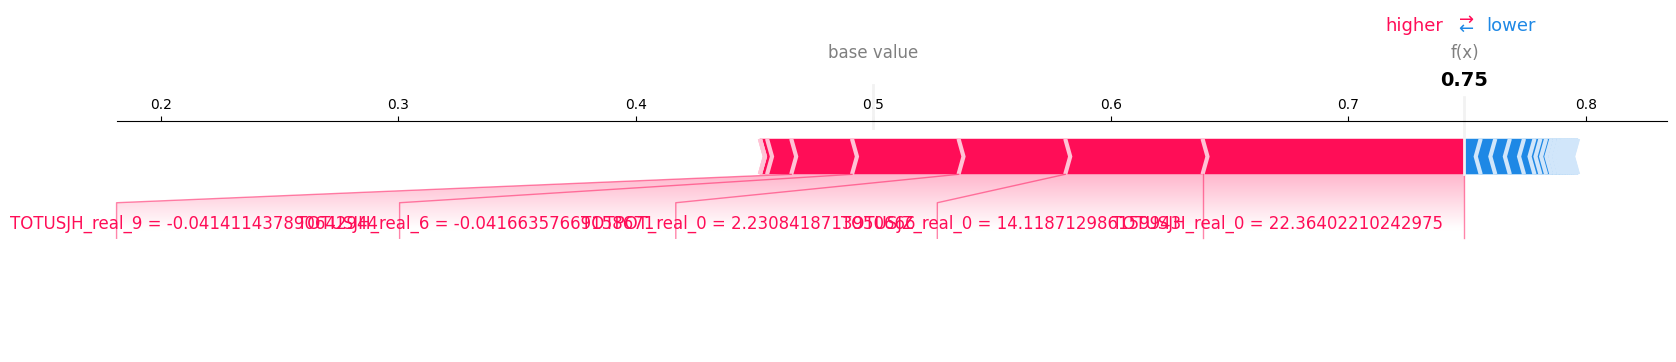

In [ ]:
shap.force_plot(
      explainer.expected_value[0],        # base value for class 0
      shap_values[0,:,0],                  # SHAP values for instance 0 and class 0
      X_instance.iloc[0],                 # raw feature values for the instance
      matplotlib=True,
      show=True
  )
#plt.savefig(os.path.join('/content', 'force.png'), dpi=300, bbox_inches='tight')
#plt.close()

## Waterfall plots

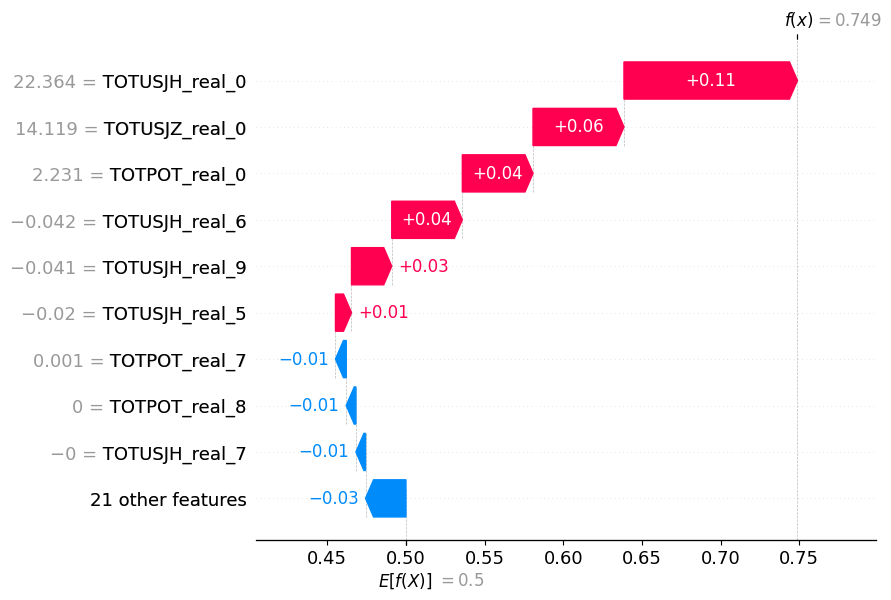

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0,:,0],
        base_values=explainer.expected_value[0],
        data=X_instance.iloc[0],
        feature_names=X_instance.columns.tolist()
    ),
    max_display=10
    )
fig.savefig("shap_waterfall.png", dpi=300, bbox_inches='tight')
plt.close(fig)

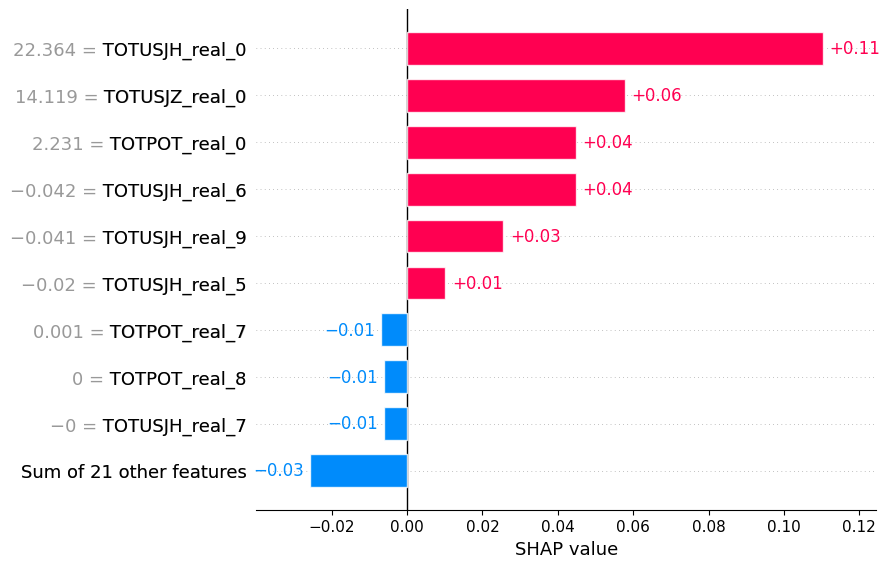

In [ ]:
shap.plots.bar(shap.Explanation(
        values=shap_values[0,:,0],
        base_values=explainer.expected_value[0],
        data=X_instance.iloc[0],
        feature_names=X_instance.columns.tolist()
    ),
    max_display=10)

In [ ]:
!wget https://www.dropbox.com/scl/fi/kmbx0skl79yk3ywk3jfkq/partition4_instances.tar.gz?rlkey=sx3lijmh7foyzy736hfym87cs&st=1gtxbj90&dl=0
!tar -xzvf /content/partition4_instances.tar.gz?rlkey=sx3lijmh7foyzy736hfym87cs&st=1gtxbj90

Streaming output truncated to the last 5000 lines.
partition4/NF/FQ_ar4422_s2014-08-06T05:36:00_e2014-08-06T17:24:00.csv
partition4/NF/FQ_ar4998_s2014-12-30T11:24:00_e2014-12-30T23:12:00.csv
partition4/NF/FQ_ar4955_s2014-12-24T16:24:00_e2014-12-25T04:12:00.csv
partition4/NF/FQ_ar4724_s2014-10-26T09:24:00_e2014-10-26T21:12:00.csv
partition4/NF/FQ_ar5198_s2015-02-12T22:36:00_e2015-02-13T10:24:00.csv
partition4/NF/FQ_ar4718_s2014-10-29T04:36:00_e2014-10-29T16:24:00.csv
partition4/NF/FQ_ar4527_s2014-09-02T12:48:00_e2014-09-03T00:36:00.csv
partition4/NF/C3.7@9568:Primary_ar4941_s2014-12-23T03:00:00_e2014-12-23T14:48:00.csv
partition4/NF/FQ_ar4469_s2014-08-21T00:48:00_e2014-08-21T12:36:00.csv
partition4/NF/FQ_ar5125_s2015-01-30T00:24:00_e2015-01-30T12:12:00.csv
partition4/NF/FQ_ar4421_s2014-08-03T15:12:00_e2014-08-04T03:00:00.csv
partition4/NF/FQ_ar4228_s2014-06-20T04:24:00_e2014-06-20T16:12:00.csv
partition4/NF/FQ_ar5225_s2015-02-20T19:24:00_e2015-02-21T07:12:00.csv
partition4/NF/C6.7@9274:

# Run Code for all Instances

In [ ]:
BASE_DIR = '/content/partition4/FL'
results = {}

In [ ]:
model = None
meta_dict = None

with open('/content/drive/MyDrive/ADM/results/part_123/rf_clf.pkl', 'rb') as f:
  model = pickle.load(f)

with open('/content/drive/MyDrive/ADM/partition1/swan-sf-metadata.pkl', 'rb') as f:
  meta_dict = pickle.load(f)

interacting_columns = ['TOTUSJH', 'TOTPOT', 'TOTUSJZ']

for idx, filename in enumerate(os.listdir(BASE_DIR)):
  #if idx == 10:
   # break
  file_path = os.path.join(BASE_DIR, filename)
  file_info = process_filename(file_path)
  results[file_info['filename']] = {}
  instance_df = pd.read_csv(file_path, sep='\t', usecols=interacting_columns)
  max_window_start, max_window_size, max_confidence = run_tail_chopping_algorithm(instance_df, model, file_info, freq_modes=10)
  results[file_info['filename']]['local_start'] = max_window_start

  results[file_info['filename']]['local_end'] = max_window_start + max_window_size
  results[file_info['filename']]['local_size'] = max_window_size
  results[file_info['filename']]['max_confidence'] = max_confidence
  for k, v in file_info.items():
    if k == 'filename':
      continue
    results[file_info['filename']][k] = v


Streaming output truncated to the last 5000 lines.
Localized window start: 0, end: 60, confidence: -1
parent_conf[0-60]: 0.6049353858874524, child_1_confidence[0-52]: 0.5456248059267501, child_2_confidence[8-60]: 0.565368432767104
parent_conf[0-60]: 0.6049353858874524, child_1_confidence[0-56]: 0.5718678654016189, child_2_confidence[4-60]: 0.5800472733273165
parent_conf[0-60]: 0.6049353858874524, child_1_confidence[0-58]: 0.582279249094977, child_2_confidence[2-60]: 0.6037147420374206
parent_conf[0-60]: 0.6049353858874524, child_1_confidence[0-59]: 0.5859779658612524, child_2_confidence[1-60]: 0.6011152407571959
Localized window start: 0, end: 60, confidence: 0.6049353858874524
parent_conf[0-60]: 0.6988042034232358, child_1_confidence[0-52]: 0.6907758445035458, child_2_confidence[8-60]: 0.6759548061359558
parent_conf[0-60]: 0.6988042034232358, child_1_confidence[0-56]: 0.6841860517197752, child_2_confidence[4-60]: 0.6687599475063375
parent_conf[0-60]: 0.6988042034232358, child_1_confid

In [ ]:
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

,local_start,local_end,local_size,max_confidence,category,class,sub_category,start_time,end_time
X2.0@9141:Primary_ar4698_s2014-10-25T08:12:00_e2014-10-25T20:00:00,32,44,12,0.814362,X,FL,2.0,2014-10-25T08:12:00,2014-10-25T20:00:00
M5.9@8793:Primary_ar4478_s2014-08-24T00:00:00_e2014-08-24T11:48:00,8,60,52,0.568375,M,FL,5.9,2014-08-24T00:00:00,2014-08-24T11:48:00
M6.1@9415:Primary_ar4874_s2014-12-04T04:24:00_e2014-12-04T16:12:00,8,60,52,0.675866,M,FL,6.1,2014-12-04T04:24:00,2014-12-04T16:12:00
M5.1@8982:Primary_ar4580_s2014-09-27T02:24:00_e2014-09-27T14:12:00,0,60,60,-1.000000,M,FL,5.1,2014-09-27T02:24:00,2014-09-27T14:12:00
M1.0@9551:Primary_ar4941_s2014-12-20T03:00:00_e2014-12-20T14:48:00,8,20,12,0.560927,M,FL,1.0,2014-12-20T03:00:00,2014-12-20T14:48:00
...,...,...,...,...,...,...,...,...,...
M2.3@8964:Primary_ar4580_s2014-09-23T10:24:00_e2014-09-23T22:12:00,0,60,60,-1.000000,M,FL,2.3,2014-09-23T10:24:00,2014-09-23T22:12:00
X1.8@9541:Primary_ar4920_s2014-12-18T22:12:00_e2014-12-19T10:00:00,24,36,12,0.563238,X,FL,1.8,2014-12-18T22:12:00,2014-12-19T10:00:00
M1.2@9550:Primary_ar4920_s2014-12-20T12:12:00_e2014-12-21T00:00:00,0,60,60,-1.000000,M,FL,1.2,2014-12-20T12:12:00,2014-12-21T00:00:00
M5.7@9305:Primary_ar4817_s2014-11-16T00:12:00_e2014-11-16T12:00:00,0,60,60,-1.000000,M,FL,5.7,2014-11-16T00:12:00,2014-11-16T12:00:00


In [ ]:
SAVE_DIR = '/content/drive/MyDrive/ADM/results/shap_results/'
#results_df.to_csv(os.path.join(SAVE_DIR, 'tail_chopping_results.csv'))

In [ ]:
def save_plots(shap_values, explainer, X_instance, base_filepath, figsize=(10,6)):
  #shap.initjs()
  fig, ax = plt.subplots(figsize=figsize)
  ax = shap.plots.waterfall(
      shap.Explanation(
          values=shap_values[0,:,0],
          base_values=explainer.expected_value[0],
          data=X_instance.iloc[0],
          feature_names=X_instance.columns.tolist()
      ),
      max_display=10,
      show=False
      )
  fig.savefig(os.path.join(base_filepath, 'waterfall.png'), dpi=300, bbox_inches='tight')
  plt.close(fig)

  plt.figure(figsize=(12, 2))
  shap.force_plot(
        explainer.expected_value[0],
        shap_values[0,:,0],
        X_instance.iloc[0],
        matplotlib=True,
        show=False
    )
  plt.savefig(os.path.join(base_filepath, 'force.png'), dpi=300, bbox_inches='tight')
  plt.close()

  fig, ax = plt.subplots(figsize=figsize)
  ax = shap.plots.bar(
      shap.Explanation(
        values=shap_values[0,:,0],
        base_values=explainer.expected_value[0],
        data=X_instance.iloc[0],
        feature_names=X_instance.columns.tolist()
      ),
      max_display=10,
      show=False
    )
  fig.savefig(os.path.join(base_filepath, 'bar.png'), dpi=300, bbox_inches='tight')
  plt.close(fig)
  return


In [ ]:
X_test = None
SAVE_INSTANCES = os.path.join(SAVE_DIR, 'instances')
for idx, filename in enumerate(os.listdir(BASE_DIR)):
  #if idx == 10:
    #break

  file_path = os.path.join(BASE_DIR, filename)
  file_info = process_filename(file_path)

  instance_df = pd.read_csv(file_path, sep='\t', usecols=interacting_columns)
  instance_df = instance_df.iloc[results_df.loc[file_info['filename'], 'local_start']: results_df.loc[file_info['filename'], 'local_end']]

  freq_df = process_file(instance_df, interacting_columns, meta_dict, file_info, 10)
  X_df = freq_df[[col for col in freq_df.columns if col != 'class']]
  y_df = freq_df['class']

  X_instance = X_df
  if X_test is None:
    X_test = X_instance
  else:
    X_test = pd.concat([X_test, X_instance]).reset_index(drop=True)

  #os.makedirs(os.path.join(SAVE_INSTANCES, file_info['filename']), exist_ok=True)

  #explainer = shap.TreeExplainer(model)
  #shap_values = explainer.shap_values(X_instance)
  #save_plots(shap_values, explainer, X_instance, os.path.join(SAVE_INSTANCES, file_info['filename']))


In [ ]:
save_plots(shap_values, explainer, X_instance, '/content')

In [ ]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [99]:
shap.initjs()
force_plot = shap.force_plot(
        explainer.expected_value[0],        # base value for class 0
        shap_values[:100,:,0],                  # SHAP values for instance 0 and class 0
        X_test.iloc[:100]
)

In [100]:
shap.save_html("shap_force_multiple.html", force_plot)

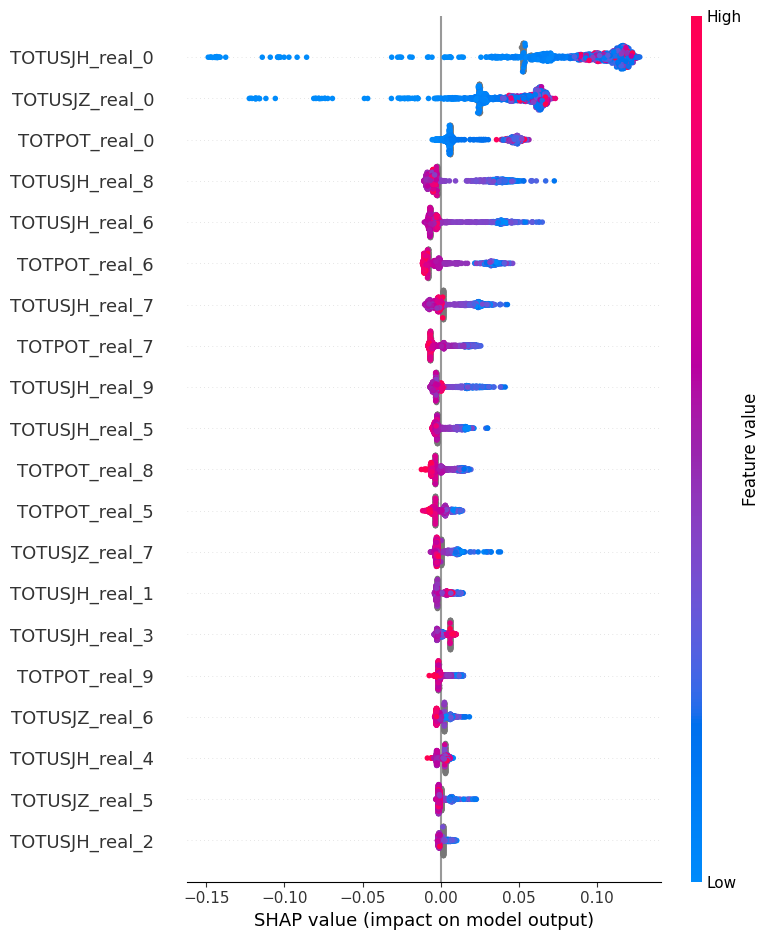

In [101]:
shap.summary_plot(shap_values[:,:,0], X_test)

In [111]:
for name in X_test.columns:
  fig, ax = plt.subplots(figsize=(8, 5))
  shap.dependence_plot(name, shap_values[:,:,0], X_test, display_features=X_test, ax=ax, show=False)
  plt.tight_layout()
  fig.savefig(os.path.join(SAVE_DIR, f'cumulative_plots/dependence_plots/{name.split("_")[0]}/{name}.png'), dpi=300)
  plt.close(fig)

# Re-construct Wave and Compare with original Signal

In [ ]:
actual_data_dict = {}
for i, col in enumerate(interacting_columns):
  y = instance_df[col].values
  y = min_max_scaling(y, meta_dict[col]['min'], meta_dict[col]['max'])
  actual_data_dict[col] = y

In [ ]:
important_freq = {}
for col in interacting_columns:
  important_freq[col] = np.zeros((10,))
  for i in range(10):
    important_freq[col][i] = freq_df[f'{col}_real_{i}'].iloc[0]

In [ ]:
reconstructed_signal = {k:np.empty((60,))*np.nan for k in interacting_columns}
for col in interacting_columns:
  y_r = np.fft.irfft(important_freq[col], n=max_window_size)
  reconstructed_signal[col][max_window_start:max_window_start+ max_window_size] = y_r

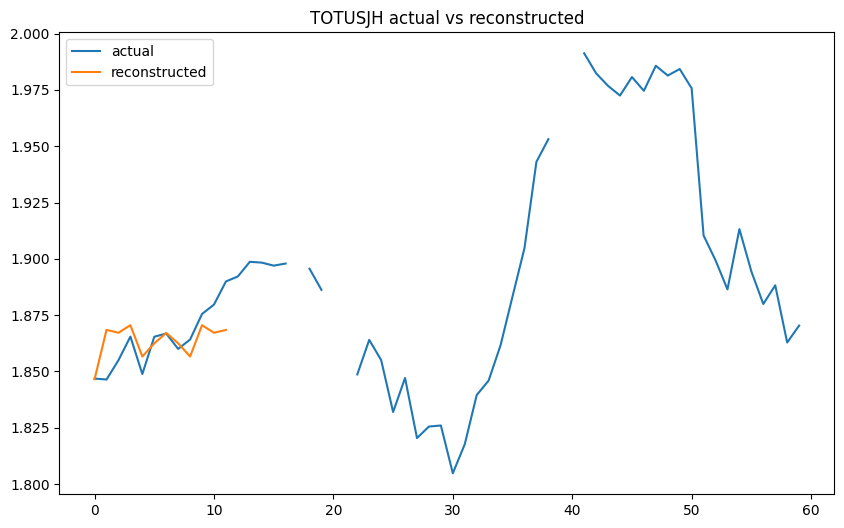

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(actual_data_dict['TOTUSJH'], label='actual')
plt.plot(reconstructed_signal['TOTUSJH'], label='reconstructed')
plt.title('TOTUSJH actual vs reconstructed')
plt.legend()
plt.show()

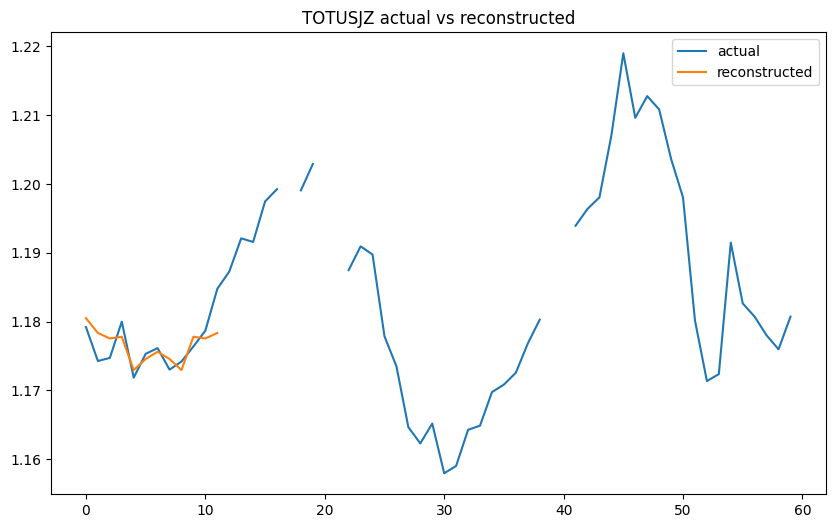

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(actual_data_dict['TOTUSJZ'], label='actual')
plt.plot(reconstructed_signal['TOTUSJZ'], label='reconstructed')
plt.title('TOTUSJZ actual vs reconstructed')
plt.legend()
plt.show()

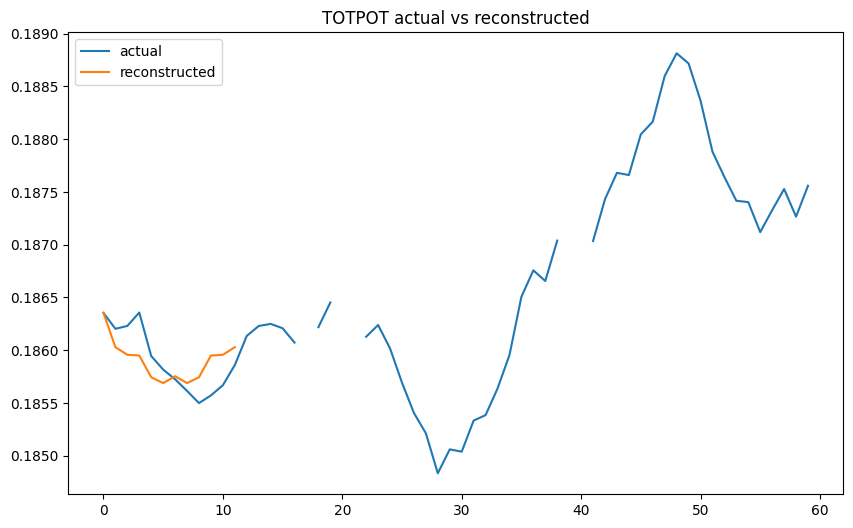

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.plot(actual_data_dict['TOTPOT'], label='actual')
plt.plot(reconstructed_signal['TOTPOT'], label='reconstructed')
plt.title('TOTPOT actual vs reconstructed')
plt.legend()
plt.show()

In [ ]:
freq_df

,TOTUSJH_real_0,TOTUSJH_real_1,TOTUSJH_real_2,TOTUSJH_real_3,TOTUSJH_real_4,TOTUSJH_real_5,TOTUSJH_real_6,TOTUSJH_real_7,TOTUSJH_real_8,TOTUSJH_real_9,...,TOTUSJZ_real_1,TOTUSJZ_real_2,TOTUSJZ_real_3,TOTUSJZ_real_4,TOTUSJZ_real_5,TOTUSJZ_real_6,TOTUSJZ_real_7,TOTUSJZ_real_8,TOTUSJZ_real_9,class
0,22.364022,0.000314,-0.020297,-0.041664,-0.000028,-0.020297,-0.041664,-0.000028,-0.018715,-0.041411,...,0.016021,0.00293,-0.004299,0.008317,0.00293,-0.004299,0.008317,-0.002522,-0.008924,FL


In [ ]:
results_df.sort_values(by='local_size').head(n=10)

NameError: name 'results_df' is not defined

In [ ]:
results_df.groupby('category')['local_size'].mean()

,local_size
category,
M,51.565217
X,33.699346


In [ ]:
meta_dict

{'TOTUSJH': {'min': 0.0, 'max': 6078.23759924654},
 'TOTPOT': {'min': 0.0, 'max': 2.820688751045556e+25},
 'TOTUSJZ': {'min': 0.0, 'max': 187665592928940.44}}

In [105]:
X_test

,TOTUSJH_real_0,TOTUSJH_real_1,TOTUSJH_real_2,TOTUSJH_real_3,TOTUSJH_real_4,TOTUSJH_real_5,TOTUSJH_real_6,TOTUSJH_real_7,TOTUSJH_real_8,TOTUSJH_real_9,...,TOTUSJZ_real_0,TOTUSJZ_real_1,TOTUSJZ_real_2,TOTUSJZ_real_3,TOTUSJZ_real_4,TOTUSJZ_real_5,TOTUSJZ_real_6,TOTUSJZ_real_7,TOTUSJZ_real_8,TOTUSJZ_real_9
0,26.077691,0.035514,-0.053839,-0.081287,-0.076636,-0.053839,-0.081287,-0.076636,-0.056937,-0.086090,...,14.968904,0.016538,0.021830,0.012820,0.010496,0.021830,0.012820,0.010496,0.008810,0.007680
1,12.657894,-0.230018,-0.174194,0.117211,-0.053572,-0.007311,-0.008143,0.002490,-0.002111,-0.005916,...,8.207808,-0.196489,-0.074870,0.070511,-0.048331,-0.012670,-0.016217,0.008219,0.001504,-0.005223
2,22.243624,0.304192,0.041562,0.037724,0.080585,-0.005495,0.034571,0.002397,0.006819,0.011787,...,14.085497,0.083837,0.097472,0.032275,0.044982,0.011999,0.023431,0.028218,0.016571,0.012095
3,53.833884,-0.319026,-0.344739,0.270861,0.010198,-0.023729,-0.060895,0.008830,0.004272,0.018281,...,37.099155,-0.128497,-0.157711,0.100890,0.023236,-0.026327,-0.032219,0.019096,0.008921,0.002434
4,NaN,NaN,NaN,-0.015036,NaN,NaN,-0.015036,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.010092,NaN,NaN,-0.010092,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,36.807966,-0.227078,0.129308,-0.177584,0.080351,0.009765,-0.027851,-0.025731,-0.003004,-0.039961,...,25.596268,-0.402276,0.259042,-0.104351,0.016376,-0.015428,-0.031240,-0.035730,-0.017185,-0.023141
1161,14.581874,0.001118,0.016323,-0.001378,-0.003791,0.016323,-0.001378,-0.003791,0.024957,-0.017422,...,9.606445,-0.015193,0.007299,-0.004035,-0.021267,0.007299,-0.004035,-0.021267,0.018623,-0.033830
1162,62.273702,-0.132367,0.318469,0.095023,0.084886,0.080724,0.096999,0.103396,0.066966,0.073365,...,40.069294,-0.109248,0.232064,0.005723,0.028801,0.036604,0.028536,0.051165,0.042711,0.041682
1163,81.059160,-0.338372,-0.598709,-0.023270,0.008328,0.007928,0.048645,0.030360,0.043169,-0.004097,...,50.457465,-0.538154,-0.424780,0.083162,-0.033008,0.024266,0.021406,0.022802,0.035431,0.013999


In [ ]:
results_df = pd.read_csv(os.path.join(SAVE_DIR, 'tail_chopping_results.csv'), index_col=0)
results_df

,local_start,local_end,local_size,max_confidence,category,class,sub_category,start_time,end_time
X2.0@9141:Primary_ar4698_s2014-10-25T08:12:00_e2014-10-25T20:00:00,32,44,12,0.814362,X,FL,2.0,2014-10-25T08:12:00,2014-10-25T20:00:00
M5.9@8793:Primary_ar4478_s2014-08-24T00:00:00_e2014-08-24T11:48:00,8,60,52,0.568375,M,FL,5.9,2014-08-24T00:00:00,2014-08-24T11:48:00
M6.1@9415:Primary_ar4874_s2014-12-04T04:24:00_e2014-12-04T16:12:00,8,60,52,0.675866,M,FL,6.1,2014-12-04T04:24:00,2014-12-04T16:12:00
M5.1@8982:Primary_ar4580_s2014-09-27T02:24:00_e2014-09-27T14:12:00,0,60,60,-1.000000,M,FL,5.1,2014-09-27T02:24:00,2014-09-27T14:12:00
M1.0@9551:Primary_ar4941_s2014-12-20T03:00:00_e2014-12-20T14:48:00,8,20,12,0.560927,M,FL,1.0,2014-12-20T03:00:00,2014-12-20T14:48:00
...,...,...,...,...,...,...,...,...,...
M2.3@8964:Primary_ar4580_s2014-09-23T10:24:00_e2014-09-23T22:12:00,0,60,60,-1.000000,M,FL,2.3,2014-09-23T10:24:00,2014-09-23T22:12:00
X1.8@9541:Primary_ar4920_s2014-12-18T22:12:00_e2014-12-19T10:00:00,24,36,12,0.563238,X,FL,1.8,2014-12-18T22:12:00,2014-12-19T10:00:00
M1.2@9550:Primary_ar4920_s2014-12-20T12:12:00_e2014-12-21T00:00:00,0,60,60,-1.000000,M,FL,1.2,2014-12-20T12:12:00,2014-12-21T00:00:00
M5.7@9305:Primary_ar4817_s2014-11-16T00:12:00_e2014-11-16T12:00:00,0,60,60,-1.000000,M,FL,5.7,2014-11-16T00:12:00,2014-11-16T12:00:00


In [ ]:
np.savez_compressed(os.path.join(SAVE_DIR, 'X_test.npz'), X_test)

In [8]:
SAVE_DIR = '/content/drive/MyDrive/ADM/results/shap_results/cumulative_plots/dependence_plots'

In [10]:
import matplotlib.image as mpimg

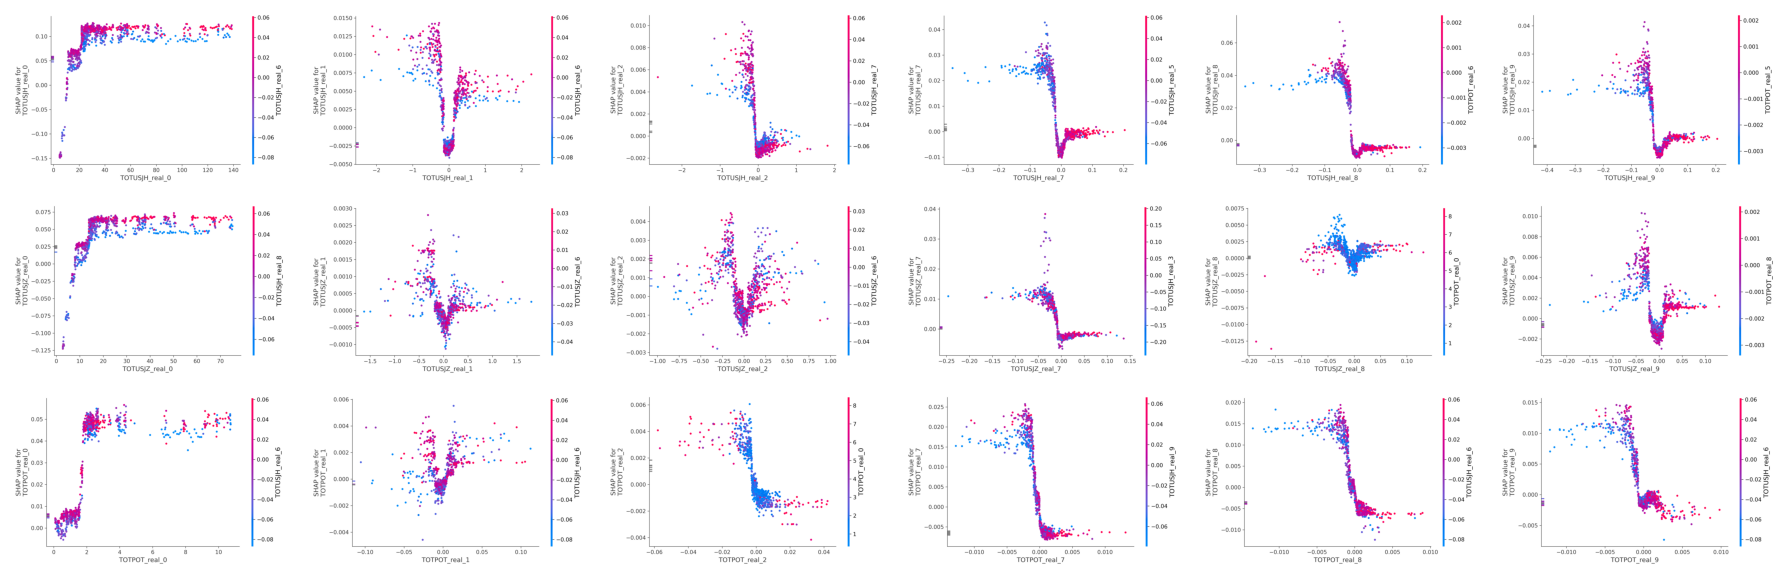

In [27]:
fig, ax = plt.subplots(3, 6, figsize=(18, 6))
for i, feature in enumerate(os.listdir(SAVE_DIR)):
  for j, filename in enumerate(os.listdir(os.path.join(SAVE_DIR, feature))):
    if j in (3,4,5,6):
      continue
    k = j
    if j >= 7:
      k -= 4
    img = mpimg.imread(os.path.join(SAVE_DIR, feature, filename))
    ax[i, k].imshow(img)
    ax[i, k].axis('off')
plt.tight_layout()
plt.show()
plt.close(fig)

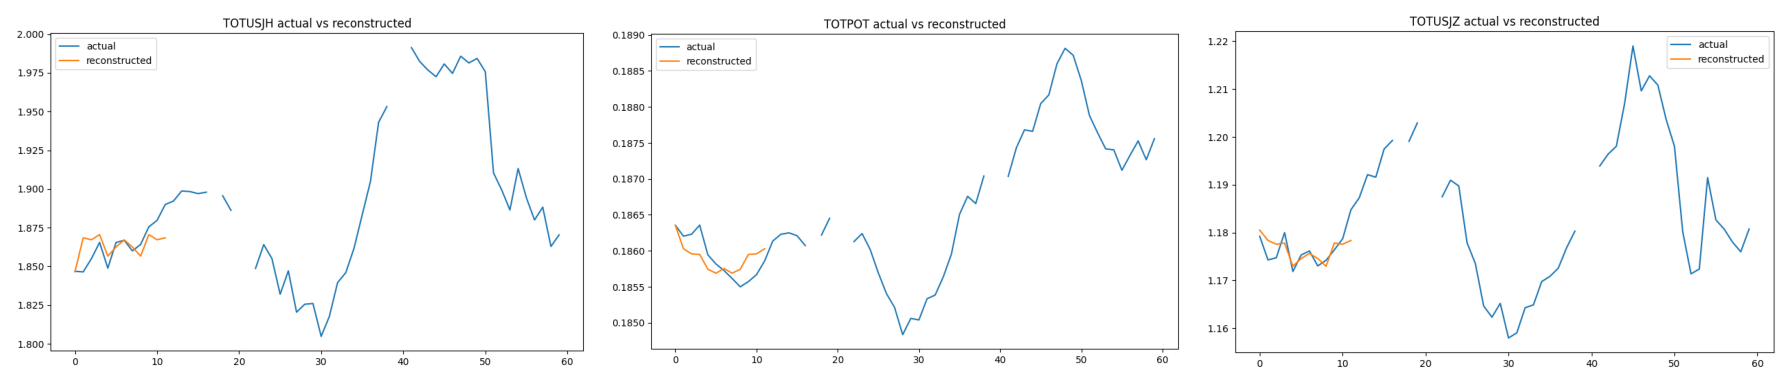

In [30]:
SAVE_DIR = '/content/drive/MyDrive/ADM/results/shap_results/cumulative_plots/reconstruction'
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, feature in enumerate(interacting_columns):

  img = mpimg.imread(os.path.join(SAVE_DIR, f'{feature}.png'))
  ax[i].imshow(img)
  ax[i].axis('off')
plt.tight_layout()
plt.show()
plt.close(fig)